# Get the data

In [341]:
import pytz
from datetime import datetime, timedelta
import pandas as pd
import requests


# API
city_name = 'Melbourne'
API_KEY = '6456aee2ec2d47df861f5e544387a73c'
lat = -37.810236
lon = 144.962765
timezone = 'Australia/Melbourne'

melbourne_tz = pytz.timezone(timezone)

# Start date: Last week of November
start_time = melbourne_tz.localize(datetime(2024, 11, 24, 0, 0))
# End date: Current time + 1 day
end_time = melbourne_tz.localize(datetime.now() + timedelta(days=1))

def convert_to_utc(date):
    utc_date = date.astimezone(pytz.utc)
    utc_timestamp = int(utc_date.timestamp())
    return utc_timestamp

start_time = convert_to_utc(start_time)
end_time = convert_to_utc(end_time)

forecast_url = f"https://pro.openweathermap.org/data/2.5/forecast/hourly?lat={lat}&lon={lon}&appid={API_KEY}"

historical_url = f"https://history.openweathermap.org/data/2.5/history/city?lat={lat}&lon={lon}&type=hour&start={start_time}&end={end_time}&appid={API_KEY}"

forecast_weather = requests.get(forecast_url)

historical_weather = requests.get(historical_url)

forecast_weather = forecast_weather.json()
historical_weather = historical_weather.json()

In [342]:
print(historical_url)

https://history.openweathermap.org/data/2.5/history/city?lat=-37.810236&lon=144.962765&type=hour&start=1732366800&end=1733464795&appid=6456aee2ec2d47df861f5e544387a73c


# Prepeare the data

In [343]:
from datetime import datetime
import pytz
import pandas as pd

def formate_weather_data(jason):
    df = pd.DataFrame(jason['list'])

    # Extract relevant columns
    df['temp'] = df['main'].apply(lambda x: x['temp'] - 273.15)  # Convert Kelvin to Celsius
    df['humidity'] = df['main'].apply(lambda x: x['humidity'])

    df['rain'] = df['rain'].apply(lambda x: x.get('1h', 0) if isinstance(x, dict) else 0)
    
    df['clouds'] = df['clouds'].apply(lambda x: x['all'])

    # Convert Unix timestamp to Melbourne local time
    melbourne_tz = pytz.timezone(timezone)
    df['datetime_melbourne'] = df['dt'].apply(
        lambda x: pytz.utc.localize(datetime.utcfromtimestamp(x)).astimezone(melbourne_tz)
    )

    # Set datetime as index
    df.set_index('datetime_melbourne', inplace=True)

    # Keep only relevant columns
    df = df[['temp', 'humidity', 'rain', 'clouds']]

    return df

forecast_df = formate_weather_data(forecast_weather)
historical_df = formate_weather_data(historical_weather)

print(forecast_df.head(1))
print(historical_df.tail(1))

                            temp  humidity  rain  clouds
datetime_melbourne                                      
2024-12-06 03:00:00+11:00  20.17        58   0.0      49
                            temp  humidity  rain  clouds
datetime_melbourne                                      
2024-12-01 00:00:00+11:00  19.03        82   0.0       0


In [344]:
import numpy as np

# Step 1: Get the last timestamp from historical data and first from forecast data
last_historical_time = historical_df.index[-1]
first_forecast_time = forecast_df.index[0]

# Step 2: Check if there is a gap
if first_forecast_time > last_historical_time + pd.Timedelta(hours=1):
    print("There is a gap between historical and forecast data.")
    # Step 3: Generate missing timestamps
    missing_times = pd.date_range(
        start=last_historical_time + pd.Timedelta(hours=1),
        end=first_forecast_time - pd.Timedelta(hours=1),
        freq='H',
        tz=historical_df.index.tz
    )

    # Step 4: Create a DataFrame for the missing times and interpolate
    missing_data = pd.DataFrame(index=missing_times, columns=historical_df.columns)
    for col in missing_data.columns:
        missing_data[col] = np.linspace(
            historical_df.iloc[-1][col],  # Last value from historical
            forecast_df.iloc[0][col],    # First value from forecast
            len(missing_times)
        )

    # Step 5: Combine DataFrames
    combined_df = pd.concat([historical_df, missing_data, forecast_df])
else:
    # No missing times, just concatenate
    print("No gap between historical and forecast data.")
    combined_df = pd.concat([historical_df, forecast_df])

# Ensure the index is sorted (just in case)
combined_df.sort_index(inplace=True)

combined_df

There is a gap between historical and forecast data.


,temp,humidity,rain,clouds
2024-11-24 00:00:00+11:00,21.13,65.0,0.33,100.0
2024-11-24 01:00:00+11:00,19.98,67.0,0.73,100.0
2024-11-24 02:00:00+11:00,20.01,75.0,0.80,100.0
2024-11-24 03:00:00+11:00,20.09,81.0,1.13,100.0
2024-11-24 04:00:00+11:00,19.85,84.0,0.71,100.0
...,...,...,...,...
2024-12-09 22:00:00+11:00,16.24,68.0,0.00,0.0
2024-12-09 23:00:00+11:00,15.81,70.0,0.00,10.0
2024-12-10 00:00:00+11:00,15.53,72.0,0.00,100.0
2024-12-10 01:00:00+11:00,15.12,75.0,0.00,87.0


In [345]:
# Generate a complete hourly range from the min to max timestamps in the index
complete_index = pd.date_range(
    start=combined_df.index.min(),
    end=combined_df.index.max(),
    freq='H',
    tz=combined_df.index.tz  # Maintain the timezone
)

# Find missing timestamps
missing_hours = complete_index.difference(combined_df.index)

# Output the missing hours
if len(missing_hours) > 0:
    print("Missing Hours:")
    print(missing_hours)
else:
    print("No missing hours in the index.")


No missing hours in the index.


# Add pedestriants of the last file

In [346]:
pedestriants_nov = pd.read_csv('..\\data\\raw\\November_2024.csv', index_col=0)
past_ped = pedestriants_nov[['Hour','Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)']]
past_ped.head(1)

,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South)
Date,,,,,,
01/11/2024,0,177,9,494,814,478


In [347]:
past_ped = past_ped.reset_index()  # Ensure date is a regular column for combination
past_ped['datetime'] = pd.to_datetime(
    past_ped['Date'] + ' ' + past_ped['Hour'].astype(str) + ':00',
    dayfirst=True  # Handle DD/MM/YYYY format
)

In [348]:
# Drop the original Date and Hour columns, keep the combined datetime column
past_ped = past_ped.drop(columns=['Date', 'Hour'])
past_ped.set_index('datetime', inplace=True)

# Print to verify
past_ped

,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South)
datetime,,,,,
2024-11-01 00:00:00,177,9,494,814,478
2024-11-01 01:00:00,126,11,278,467,334
2024-11-01 02:00:00,81,1,192,224,238
2024-11-01 03:00:00,55,2,96,113,190
2024-11-01 04:00:00,54,12,84,77,133
...,...,...,...,...,...
2024-11-30 19:00:00,1038,602,2079,961,998
2024-11-30 20:00:00,1145,559,1857,971,973
2024-11-30 21:00:00,1280,503,1965,783,1015


In [349]:
# Ensure past_ped index is timezone-aware and matches the timezone of combined_df
melbourne_tz = pytz.timezone(timezone)
past_ped.index = past_ped.index.tz_localize(melbourne_tz)

# Merge after aligning time zones
merged_df = combined_df.merge(
    past_ped,
    left_index=True,
    right_index=True,
    how='left'
)

merged_df

,temp,humidity,rain,clouds,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South)
2024-11-24 00:00:00+11:00,21.13,65.0,0.33,100.0,433.0,110.0,874.0,501.0,733.0
2024-11-24 01:00:00+11:00,19.98,67.0,0.73,100.0,293.0,18.0,550.0,329.0,565.0
2024-11-24 02:00:00+11:00,20.01,75.0,0.80,100.0,224.0,8.0,338.0,242.0,347.0
2024-11-24 03:00:00+11:00,20.09,81.0,1.13,100.0,119.0,5.0,308.0,160.0,377.0
2024-11-24 04:00:00+11:00,19.85,84.0,0.71,100.0,53.0,2.0,203.0,143.0,249.0
...,...,...,...,...,...,...,...,...,...
2024-12-09 22:00:00+11:00,16.24,68.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN
2024-12-09 23:00:00+11:00,15.81,70.0,0.00,10.0,NaN,NaN,NaN,NaN,NaN
2024-12-10 00:00:00+11:00,15.53,72.0,0.00,100.0,NaN,NaN,NaN,NaN,NaN
2024-12-10 01:00:00+11:00,15.12,75.0,0.00,87.0,NaN,NaN,NaN,NaN,NaN


# Match Columns for forecast

In [350]:
import holidays

# Create a list of public holidays in Victoria
australia_holidays = holidays.Australia(state='VIC')

# Add a new column to indicate whether each date is a public holiday
merged_df['IsPublicHoliday'] = [
    1 if date in australia_holidays else 0 for date in merged_df.index.date
]

merged_df['Hour'] = merged_df.index.hour
merged_df['Weekday'] = merged_df.index.weekday + 1
merged_df['Month'] = merged_df.index.month
merged_df['Season'] = merged_df['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                                      3: 'Spring', 4: 'Spring', 5: 'Spring',
                                                      6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                      9: 'Fall', 10: 'Fall', 11: 'Fall'})

# Display the updated DataFrame
merged_df.head(3)

,temp,humidity,rain,clouds,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),IsPublicHoliday,Hour,Weekday,Month,Season
2024-11-24 00:00:00+11:00,21.13,65.0,0.33,100.0,433.0,110.0,874.0,501.0,733.0,0,0,7,11,Fall
2024-11-24 01:00:00+11:00,19.98,67.0,0.73,100.0,293.0,18.0,550.0,329.0,565.0,0,1,7,11,Fall
2024-11-24 02:00:00+11:00,20.01,75.0,0.80,100.0,224.0,8.0,338.0,242.0,347.0,0,2,7,11,Fall


In [351]:
categorical_columns = ['Weekday', 'Month', 'Season']

# Dummy-encode all categorical columns
df_with_all_dummies = pd.get_dummies(merged_df, columns=categorical_columns)

df_with_all_dummies.columns

Index(['temp', 'humidity', 'rain', 'clouds',
       'Little Collins St-Swanston St (East)', 'Faraday St-Lygon St (West)',
       'Melbourne Central', 'Chinatown-Lt Bourke St (South)',
       'Lonsdale St (South)', 'IsPublicHoliday', 'Hour', 'Weekday_1',
       'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6',
       'Weekday_7', 'Month_11', 'Month_12', 'Season_Fall', 'Season_Winter'],
      dtype='object')

In [352]:
old_columns = ['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
        'IsPublicHoliday', 'temp', 'humidity', 'rain_1h',
       'clouds_all', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Season_Spring', 'Season_Summer', 'Season_Winter']

reordered_df = df_with_all_dummies.reindex(columns=old_columns, fill_value=0)
reordered_df.columns

Index(['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'IsPublicHoliday', 'temp', 'humidity', 'rain_1h', 'clouds_all',
       'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6',
       'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

In [353]:
# Match if it is the same order
old_df = pd.read_csv('..\\data\\processed\\final_df.csv', index_col=0)

old_df.drop(columns=['Lygon St (West)'], inplace=True)

# Match if all columns have the same order
print(old_df.columns == reordered_df.columns)



reordered_df.head(3)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),IsPublicHoliday,temp,humidity,rain_1h,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Spring,Season_Summer,Season_Winter
2024-11-24 00:00:00+11:00,0,433.0,110.0,874.0,501.0,733.0,0,21.13,65.0,0,...,0,0,0,0,0,1,0,0,0,0
2024-11-24 01:00:00+11:00,1,293.0,18.0,550.0,329.0,565.0,0,19.98,67.0,0,...,0,0,0,0,0,1,0,0,0,0
2024-11-24 02:00:00+11:00,2,224.0,8.0,338.0,242.0,347.0,0,20.01,75.0,0,...,0,0,0,0,0,1,0,0,0,0


# Processing for prediction

## Use saved scaler

In [354]:
import joblib
# Load the scaler
scaler = joblib.load('models/scaler.pkl')

weather_features = ['temp', 'humidity', 'rain_1h', 'clouds_all']

# Apply the same scaling to reordered_df
reordered_df[weather_features] = scaler.transform(reordered_df[weather_features])


## Feature selection

In [355]:
# Separate features and target
target_columns = [
    'Little Collins St-Swanston St (East)', 
    'Faraday St-Lygon St (West)', 
    'Melbourne Central',
    'Chinatown-Lt Bourke St (South)',
    'Lonsdale St (South)'
]

# Add lagged features (they capture pedestrian flow from the previous hour)
for sensor in target_columns:
    reordered_df[f'{sensor}_Lag_1'] = reordered_df[sensor].shift(1)

# Add rolling averages (capture the short term trends over the last 7 hours)
for sensor in target_columns:
    reordered_df[f'Rolling_7_{sensor}'] = reordered_df[sensor].rolling(window=7, min_periods=1).mean()

# Due to the lag and rolling averages, the first 7 hours are dropped
reordered_df = reordered_df.iloc[7:]


In [356]:
#Editing the feature list
# Adding hour as a feature
reordered_df['Hour'] = reordered_df.index.hour

# interaction feature
reordered_df['Rain_Holiday'] = reordered_df['rain_1h'] * reordered_df['IsPublicHoliday']

features = [
    'IsPublicHoliday', 'Hour',
    'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'Weekday_7',
    'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
    'Season_Spring', 'Season_Summer', 'Season_Winter',
    'temp', 'humidity', 'rain_1h', 'clouds_all'
] + \
[f'Rolling_7_{sensor}' for sensor in target_columns] + \
[f'{sensor}_Lag_1' for sensor in target_columns]

reordered_df.head(2)


,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),IsPublicHoliday,temp,humidity,rain_1h,...,Faraday St-Lygon St (West)_Lag_1,Melbourne Central_Lag_1,Chinatown-Lt Bourke St (South)_Lag_1,Lonsdale St (South)_Lag_1,Rolling_7_Little Collins St-Swanston St (East),Rolling_7_Faraday St-Lygon St (West),Rolling_7_Melbourne Central,Rolling_7_Chinatown-Lt Bourke St (South),Rolling_7_Lonsdale St (South),Rain_Holiday
2024-11-24 07:00:00+11:00,7,79.0,6.0,44.0,36.0,123.0,0,0.466414,0.876404,0.0,...,9.0,39.0,21.0,134.0,125.285714,8.142857,227.571429,137.571429,289.857143,0.0
2024-11-24 08:00:00+11:00,8,84.0,44.0,74.0,33.0,118.0,0,0.461869,0.898876,0.0,...,6.0,44.0,36.0,123.0,95.428571,11.857143,159.571429,95.285714,226.000000,0.0


In [357]:
reordered_df_save = reordered_df.copy()

In [358]:
reordered_df = reordered_df_save.copy()

In [359]:
rows_to_predict = reordered_df[target_columns].isna().any(axis=1)
prediction_start = reordered_df[target_columns].isna().idxmax()[0]


# Prediction

In [360]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


In [361]:
import joblib
from tqdm import tqdm

# Iterate through rows needing predictions
for i, row in tqdm(reordered_df[rows_to_predict].iterrows(), total=len(reordered_df[rows_to_predict])):
    for street in target_columns:
        # Load the model for the specific street
        model_path = f"models/{street}_model.joblib"
        model = joblib.load(model_path)

        # Extract features for the current row
        X_current = reordered_df.loc[[i], features]

        # Predict the target value for the current row
        predicted_value = model.predict(X_current)[0]
        predicted_value = round(predicted_value)

        # Update the DataFrame with the predicted value
        reordered_df.at[i, street] = predicted_value

        # Update lagged features for the next row
        next_row_index = reordered_df.index.get_loc(i) + 1
        if next_row_index < len(reordered_df):
            next_row = reordered_df.iloc[next_row_index]
            
            # Update lagged value for the current street
            reordered_df.at[next_row.name, f'{street}_Lag_1'] = predicted_value

            # Update rolling features dynamically (if applicable)
            rolling_feature = f'Rolling_7_{street}'
            past_values = reordered_df.loc[:row.name, street].tail(7)
            reordered_df.at[next_row.name, rolling_feature] = past_values.mean()


reordered_df


100%|██████████| 219/219 [02:54<00:00,  1.26it/s]


,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),IsPublicHoliday,temp,humidity,rain_1h,...,Faraday St-Lygon St (West)_Lag_1,Melbourne Central_Lag_1,Chinatown-Lt Bourke St (South)_Lag_1,Lonsdale St (South)_Lag_1,Rolling_7_Little Collins St-Swanston St (East),Rolling_7_Faraday St-Lygon St (West),Rolling_7_Melbourne Central,Rolling_7_Chinatown-Lt Bourke St (South),Rolling_7_Lonsdale St (South),Rain_Holiday
2024-11-24 07:00:00+11:00,7,79.0,6.0,44.0,36.0,123.0,0,0.466414,0.876404,0.0,...,9.0,39.0,21.0,134.0,125.285714,8.142857,227.571429,137.571429,289.857143,0.0
2024-11-24 08:00:00+11:00,8,84.0,44.0,74.0,33.0,118.0,0,0.461869,0.898876,0.0,...,6.0,44.0,36.0,123.0,95.428571,11.857143,159.571429,95.285714,226.000000,0.0
2024-11-24 09:00:00+11:00,9,245.0,106.0,218.0,70.0,185.0,0,0.467172,0.898876,0.0,...,44.0,74.0,33.0,118.0,98.428571,25.857143,142.428571,70.714286,202.857143,0.0
2024-11-24 10:00:00+11:00,10,369.0,264.0,294.0,138.0,274.0,0,0.474747,0.898876,0.0,...,106.0,218.0,70.0,185.0,134.142857,62.857143,140.428571,67.571429,188.142857,0.0
2024-11-24 11:00:00+11:00,11,529.0,379.0,719.0,378.0,347.0,0,0.482071,0.910112,0.0,...,264.0,294.0,138.0,274.0,202.142857,116.714286,214.142857,101.142857,202.142857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09 22:00:00+11:00,22,324.0,110.0,712.0,160.0,285.0,0,0.393939,0.640449,0.0,...,212.0,987.0,212.0,359.0,649.142857,279.714286,1253.142857,255.285714,421.285714,0.0
2024-12-09 23:00:00+11:00,23,189.0,45.0,441.0,67.0,173.0,0,0.383081,0.662921,0.0,...,110.0,712.0,160.0,285.0,596.000000,257.142857,1175.857143,246.857143,401.428571,0.0
2024-12-10 00:00:00+11:00,0,88.0,18.0,212.0,30.0,95.0,0,0.376010,0.685393,0.0,...,45.0,441.0,67.0,173.0,522.000000,225.714286,1054.857143,228.571429,368.428571,0.0
2024-12-10 01:00:00+11:00,1,48.0,9.0,146.0,19.0,67.0,0,0.365657,0.719101,0.0,...,18.0,212.0,30.0,95.0,420.428571,186.142857,893.000000,201.000000,317.285714,0.0


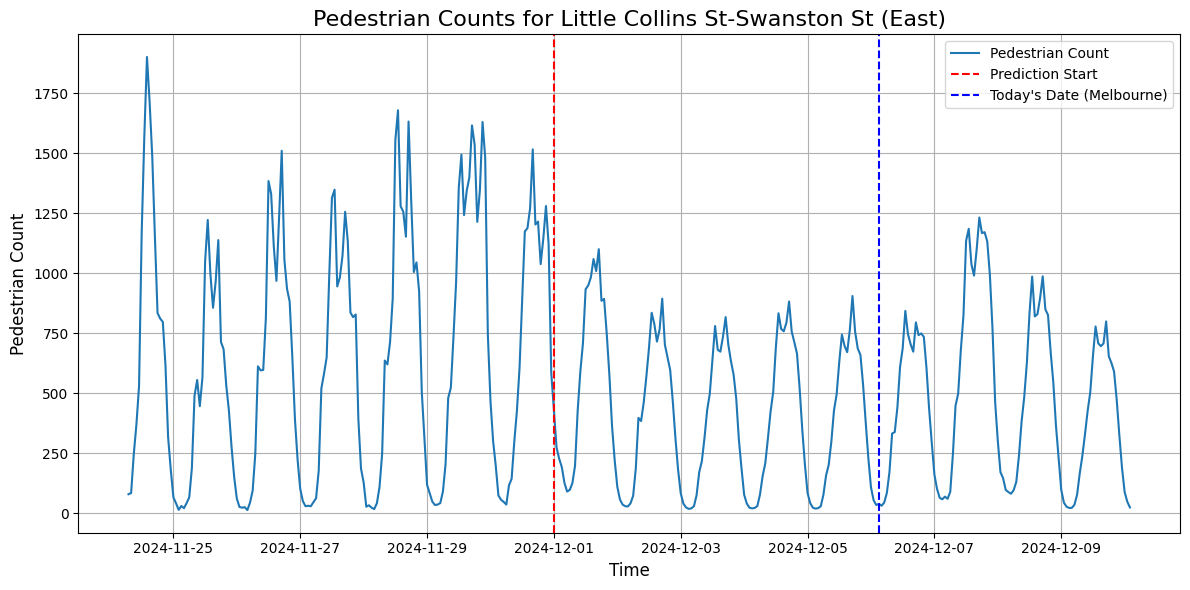

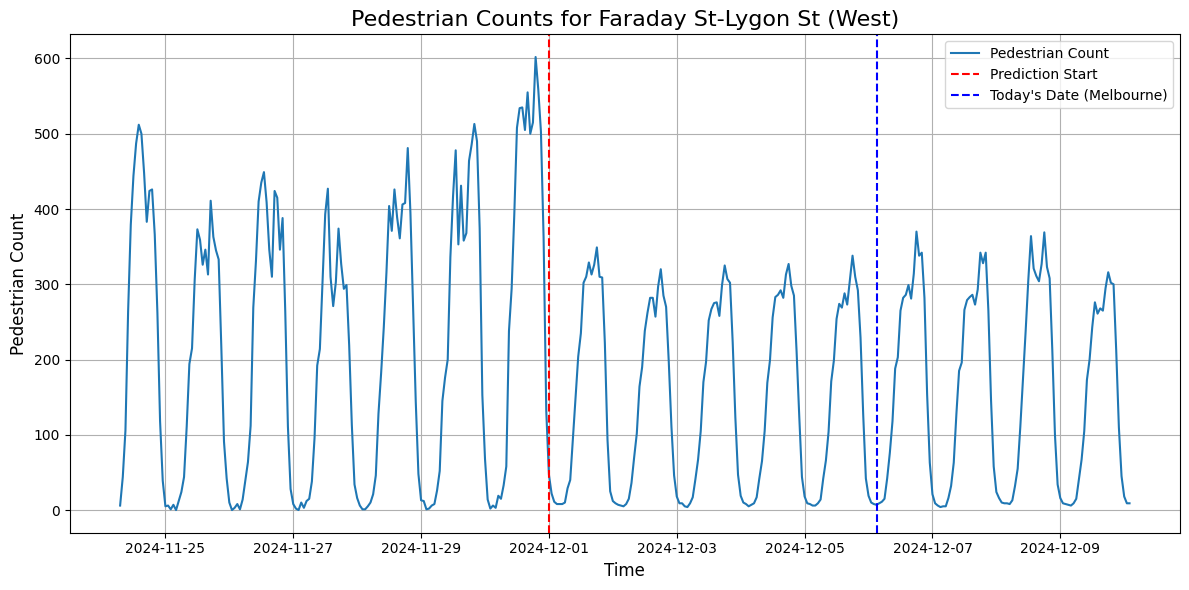

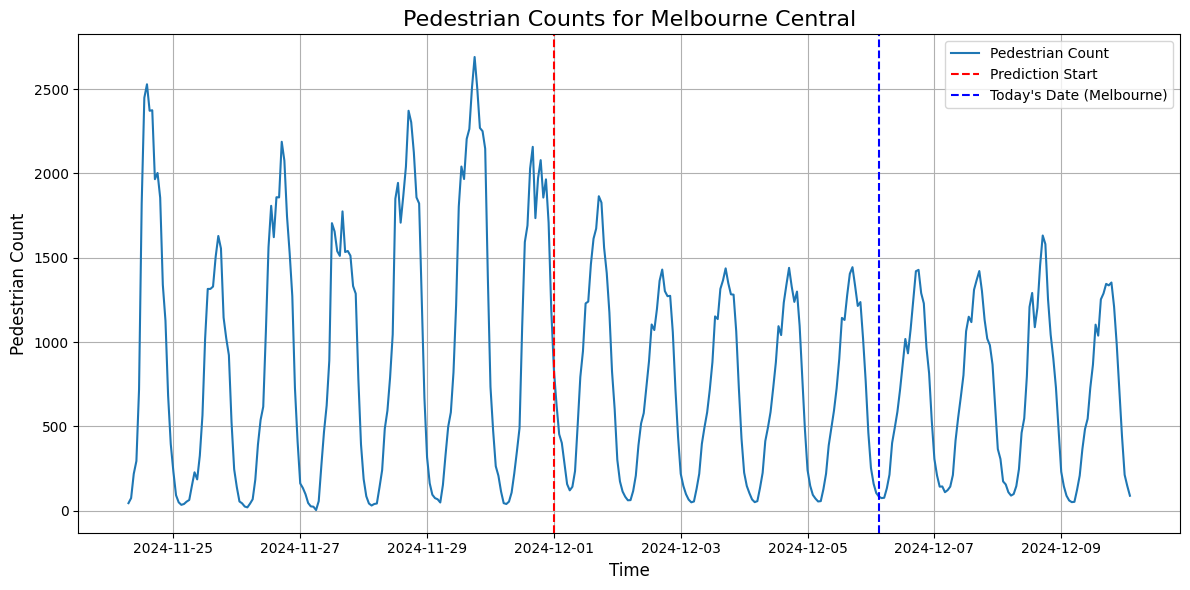

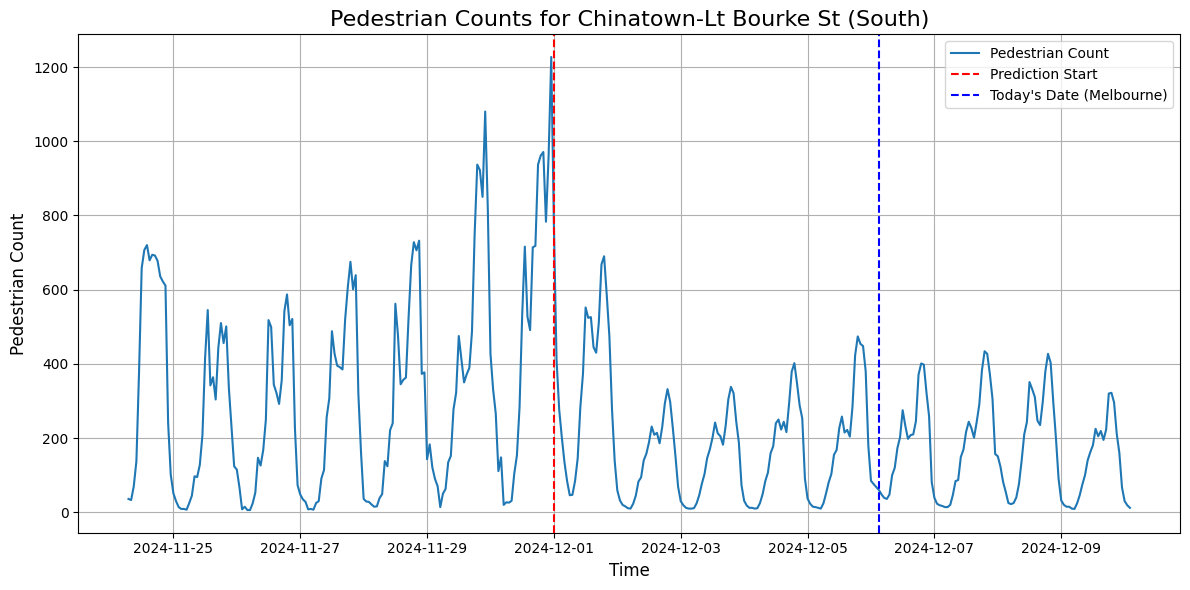

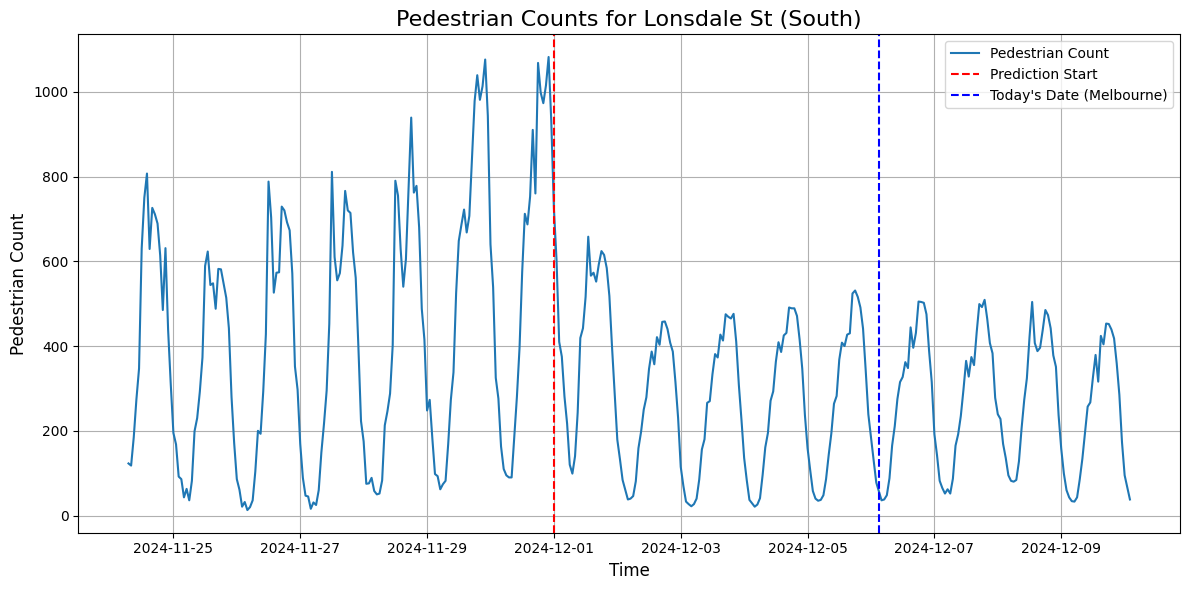

In [362]:
import matplotlib.pyplot as plt
# Plot the pedestrian counts

# Define Melbourne timezone
melbourne_tz = pytz.timezone("Australia/Melbourne")

# Get today's date in Melbourne time
today = datetime.now(melbourne_tz)


for street in target_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(reordered_df.index, reordered_df[street], label='Pedestrian Count')

    # Add a vertical line at the prediction start
    plt.axvline(x=prediction_start, color='red', linestyle='--', label='Prediction Start')
    plt.axvline(x=today, color='blue', linestyle='--', label="Today's Date (Melbourne)")

    # Add labels, title, and legend
    plt.title(f'Pedestrian Counts for {street}', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Pedestrian Count', fontsize=12)
    plt.legend()
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Saving

In [363]:
# drop all future data from today
from datetime import datetime, timedelta
import pytz

# Define Melbourne timezone
melbourne_tz = pytz.timezone("Australia/Melbourne")

# Get current time in Melbourne
now_melbourne = datetime.now(melbourne_tz)

# Define the 3-hour cutoff
cutoff_time = now_melbourne - timedelta(hours=3)

# Drop rows beyond the cutoff
cutoff_df = reordered_df[reordered_df.index <= cutoff_time]

# Save the filtered DataFrame to a CSV
cutoff_df.to_csv('pedestrian_data_filtered.csv', index=True)

cutoff_df

,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),IsPublicHoliday,temp,humidity,rain_1h,...,Faraday St-Lygon St (West)_Lag_1,Melbourne Central_Lag_1,Chinatown-Lt Bourke St (South)_Lag_1,Lonsdale St (South)_Lag_1,Rolling_7_Little Collins St-Swanston St (East),Rolling_7_Faraday St-Lygon St (West),Rolling_7_Melbourne Central,Rolling_7_Chinatown-Lt Bourke St (South),Rolling_7_Lonsdale St (South),Rain_Holiday
2024-11-24 07:00:00+11:00,7,79.0,6.0,44.0,36.0,123.0,0,0.466414,0.876404,0.0,...,9.0,39.0,21.0,134.0,125.285714,8.142857,227.571429,137.571429,289.857143,0.0
2024-11-24 08:00:00+11:00,8,84.0,44.0,74.0,33.0,118.0,0,0.461869,0.898876,0.0,...,6.0,44.0,36.0,123.0,95.428571,11.857143,159.571429,95.285714,226.000000,0.0
2024-11-24 09:00:00+11:00,9,245.0,106.0,218.0,70.0,185.0,0,0.467172,0.898876,0.0,...,44.0,74.0,33.0,118.0,98.428571,25.857143,142.428571,70.714286,202.857143,0.0
2024-11-24 10:00:00+11:00,10,369.0,264.0,294.0,138.0,274.0,0,0.474747,0.898876,0.0,...,106.0,218.0,70.0,185.0,134.142857,62.857143,140.428571,67.571429,188.142857,0.0
2024-11-24 11:00:00+11:00,11,529.0,379.0,719.0,378.0,347.0,0,0.482071,0.910112,0.0,...,264.0,294.0,138.0,274.0,202.142857,116.714286,214.142857,101.142857,202.142857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05 20:00:00+11:00,20,660.0,292.0,1237.0,454.0,491.0,0,0.491754,0.541462,0.0,...,310.0,1214.0,474.0,516.0,746.142857,294.000000,1278.285714,297.142857,462.285714,0.0
2024-12-05 21:00:00+11:00,21,537.0,229.0,1021.0,448.0,441.0,0,0.491992,0.539233,0.0,...,292.0,1237.0,454.0,491.0,734.142857,296.571429,1291.714286,325.142857,474.142857,0.0
2024-12-05 22:00:00+11:00,22,380.0,127.0,768.0,380.0,343.0,0,0.492230,0.537004,0.0,...,229.0,1021.0,448.0,441.0,711.285714,290.857143,1276.000000,358.428571,480.000000,0.0
2024-12-05 23:00:00+11:00,23,230.0,42.0,463.0,179.0,239.0,0,0.492468,0.534776,0.0,...,127.0,768.0,380.0,343.0,669.714286,267.857143,1203.000000,381.000000,468.000000,0.0


# Load the data again and do it again

In [364]:
# Load the saved CSV
saved_data = pd.read_csv('pedestrian_data_filtered.csv', index_col=0, parse_dates=True)

saved_data.tail(1)

,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),IsPublicHoliday,temp,humidity,rain_1h,...,Faraday St-Lygon St (West)_Lag_1,Melbourne Central_Lag_1,Chinatown-Lt Bourke St (South)_Lag_1,Lonsdale St (South)_Lag_1,Rolling_7_Little Collins St-Swanston St (East),Rolling_7_Faraday St-Lygon St (West),Rolling_7_Melbourne Central,Rolling_7_Chinatown-Lt Bourke St (South),Rolling_7_Lonsdale St (South),Rain_Holiday
2024-12-06 00:00:00+11:00,0,108.0,19.0,252.0,85.0,184.0,0,0.492706,0.532547,0.0,...,42.0,463.0,179.0,239.0,593.428571,234.857143,1068.428571,377.428571,440.714286,0.0


In [365]:
def formate_weather_data_new(jason):
    df = pd.DataFrame(jason['list'])

    # Extract relevant columns
    df['temp'] = df['main'].apply(lambda x: x['temp'] - 273.15)  # Convert Kelvin to Celsius
    df['humidity'] = df['main'].apply(lambda x: x['humidity'])
    
    # Ensure 'rain' column is added with 0 if 'rain' key is missing
    if 'rain' in df:
        df['rain'] = df['rain'].apply(lambda x: x.get('1h', 0) if isinstance(x, dict) else 0)
    else:
        df['rain'] = 0


    df['clouds'] = df['clouds'].apply(lambda x: x['all'])

    # Convert Unix timestamp to Melbourne local time
    melbourne_tz = pytz.timezone(timezone)
    df['datetime_melbourne'] = df['dt'].apply(
        lambda x: pytz.utc.localize(datetime.utcfromtimestamp(x)).astimezone(melbourne_tz)
    )

    # Set datetime as index
    df.set_index('datetime_melbourne', inplace=True)

    # Keep only relevant columns
    df = df[['temp', 'humidity', 'rain', 'clouds']]

    return df

In [366]:
import pytz
from datetime import datetime, timedelta
import pandas as pd
import requests


# API
city_name = 'Melbourne'
API_KEY = '6456aee2ec2d47df861f5e544387a73c'
lat = -37.810236
lon = 144.962765
timezone = 'Australia/Melbourne'

melbourne_tz = pytz.timezone(timezone)

# Identify the last timestamp in the saved CSV
last_timestamp = saved_data.index.max()

# Fetch new weather data starting from the last timestamp
new_start_time = last_timestamp + timedelta(hours=1)
new_end_time = melbourne_tz.localize(datetime.now() + timedelta(days=1))

# Convert to UTC for API queries
new_start_time_utc = int(new_start_time.astimezone(pytz.utc).timestamp())
new_end_time_utc = int(new_end_time.astimezone(pytz.utc).timestamp())

# Fetch historical and forecast weather data
historical_url = f"https://history.openweathermap.org/data/2.5/history/city?lat={lat}&lon={lon}&type=hour&start={new_start_time_utc}&end={new_end_time_utc}&appid={API_KEY}"
forecast_url = f"https://pro.openweathermap.org/data/2.5/forecast/hourly?lat={lat}&lon={lon}&appid={API_KEY}"

historical_weather = requests.get(historical_url).json()
forecast_weather = requests.get(forecast_url).json()

# Process and merge new data
historical_df = formate_weather_data_new(historical_weather)
forecast_df = formate_weather_data_new(forecast_weather)

In [367]:
import numpy as np

# Step 1: Get the last timestamp from historical data and first from forecast data
last_historical_time = historical_df.index[-1]
first_forecast_time = forecast_df.index[0]

# Step 2: Check if there is a gap
if first_forecast_time > last_historical_time + pd.Timedelta(hours=1):
    print("There is a gap between historical and forecast data.")
    # Step 3: Generate missing timestamps
    missing_times = pd.date_range(
        start=last_historical_time + pd.Timedelta(hours=1),
        end=first_forecast_time - pd.Timedelta(hours=1),
        freq='H',
        tz=historical_df.index.tz
    )

    # Step 4: Create a DataFrame for the missing times and interpolate
    missing_data = pd.DataFrame(index=missing_times, columns=historical_df.columns)
    for col in missing_data.columns:
        missing_data[col] = np.linspace(
            historical_df.iloc[-1][col],  # Last value from historical
            forecast_df.iloc[0][col],    # First value from forecast
            len(missing_times)
        )

    # Step 5: Combine DataFrames
    combined_df = pd.concat([historical_df, missing_data, forecast_df])
else:
    # No missing times, just concatenate
    print("No gap between historical and forecast data.")
    combined_df = pd.concat([historical_df, forecast_df])

# Ensure the index is sorted (just in case)
combined_df.sort_index(inplace=True)

No gap between historical and forecast data.


In [368]:
combined_df.head(1)

,temp,humidity,rain,clouds
datetime_melbourne,,,,
2024-12-06 01:00:00+11:00,21.12,53,0.0,0


In [369]:
import holidays

# Create a list of public holidays in Victoria
australia_holidays = holidays.Australia(state='VIC')

merged_df = combined_df.copy()

# Add a new column to indicate whether each date is a public holiday
merged_df['IsPublicHoliday'] = [
    1 if date in australia_holidays else 0 for date in merged_df.index.date
]

merged_df['Hour'] = merged_df.index.hour
merged_df['Weekday'] = merged_df.index.weekday + 1
merged_df['Month'] = merged_df.index.month
merged_df['Season'] = merged_df['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                                      3: 'Spring', 4: 'Spring', 5: 'Spring',
                                                      6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                      9: 'Fall', 10: 'Fall', 11: 'Fall'})

# Display the updated DataFrame
merged_df.head(3)

,temp,humidity,rain,clouds,IsPublicHoliday,Hour,Weekday,Month,Season
datetime_melbourne,,,,,,,,,
2024-12-06 01:00:00+11:00,21.12,53,0.0,0,0,1,5,12,Winter
2024-12-06 02:00:00+11:00,20.21,57,0.0,34,0,2,5,12,Winter
2024-12-06 03:00:00+11:00,20.17,58,0.0,49,0,3,5,12,Winter


In [370]:
categorical_columns = ['Weekday', 'Month', 'Season']

# Dummy-encode all categorical columns
df_with_all_dummies = pd.get_dummies(merged_df, columns=categorical_columns)

df_with_all_dummies.columns

Index(['temp', 'humidity', 'rain', 'clouds', 'IsPublicHoliday', 'Hour',
       'Weekday_1', 'Weekday_2', 'Weekday_5', 'Weekday_6', 'Weekday_7',
       'Month_12', 'Season_Winter'],
      dtype='object')

In [371]:
target_columns = [
    'Little Collins St-Swanston St (East)', 
    'Faraday St-Lygon St (West)', 
    'Melbourne Central',
    'Chinatown-Lt Bourke St (South)',
    'Lonsdale St (South)'
]

# Create NA values
for sensor in target_columns:
    df_with_all_dummies[sensor] = np.nan

In [372]:
old_columns = ['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
        'IsPublicHoliday', 'temp', 'humidity', 'rain_1h',
       'clouds_all', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Season_Spring', 'Season_Summer', 'Season_Winter']

reordered_df = df_with_all_dummies.reindex(columns=old_columns, fill_value=0)

# Add lagged features (they capture pedestrian flow from the previous hour)
for sensor in target_columns:
    reordered_df[f'{sensor}_Lag_1'] = reordered_df[sensor].shift(1)

# Add rolling averages (capture the short term trends over the last 7 hours)
for sensor in target_columns:
    reordered_df[f'Rolling_7_{sensor}'] = reordered_df[sensor].rolling(window=7, min_periods=1).mean()


In [373]:
import joblib
# Load the scaler
scaler = joblib.load('models/scaler.pkl')

weather_features = ['temp', 'humidity', 'rain_1h', 'clouds_all']

# Apply the same scaling to reordered_df
reordered_df[weather_features] = scaler.transform(reordered_df[weather_features])


In [374]:
reordered_df['Hour'] = reordered_df.index.hour

# interaction feature
reordered_df['Rain_Holiday'] = reordered_df['rain_1h'] * reordered_df['IsPublicHoliday']

features = [
    'IsPublicHoliday', 'Hour',
    'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'Weekday_7',
    'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
    'Season_Spring', 'Season_Summer', 'Season_Winter',
    'temp', 'humidity', 'rain_1h', 'clouds_all'
] + \
[f'Rolling_7_{sensor}' for sensor in target_columns] + \
[f'{sensor}_Lag_1' for sensor in target_columns]


In [375]:
# Combine them and sort them
final_df = pd.concat([saved_data, reordered_df])
final_df.sort_index(inplace=True)

rows_to_predict = final_df[target_columns].isna().any(axis=1)
prediction_start = final_df[target_columns].isna().idxmax()[0]


## Prediction

In [376]:
import joblib
from tqdm import tqdm

# Iterate through rows needing predictions
for i, row in tqdm(final_df[rows_to_predict].iterrows(), total=len(final_df[rows_to_predict])):
    for street in target_columns:
        # Load the model for the specific street
        model_path = f"models/{street}_model.joblib"
        model = joblib.load(model_path)

        # Extract features for the current row
        X_current = final_df.loc[[i], features]

        # Predict the target value for the current row
        predicted_value = model.predict(X_current)[0]
        predicted_value = round(predicted_value)

        # Update the DataFrame with the predicted value
        final_df.at[i, street] = predicted_value

        # Update lagged features for the next row
        next_row_index = final_df.index.get_loc(i) + 1
        if next_row_index < len(final_df):
            next_row = final_df.iloc[next_row_index]
            
            # Update lagged value for the current street
            final_df.at[next_row.name, f'{street}_Lag_1'] = predicted_value

            # Update rolling features dynamically (if applicable)
            rolling_feature = f'Rolling_7_{street}'
            past_values = final_df.loc[:row.name, street].tail(7)
            final_df.at[next_row.name, rolling_feature] = past_values.mean()


final_df


100%|██████████| 98/98 [01:21<00:00,  1.21it/s]


,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),IsPublicHoliday,temp,humidity,rain_1h,...,Faraday St-Lygon St (West)_Lag_1,Melbourne Central_Lag_1,Chinatown-Lt Bourke St (South)_Lag_1,Lonsdale St (South)_Lag_1,Rolling_7_Little Collins St-Swanston St (East),Rolling_7_Faraday St-Lygon St (West),Rolling_7_Melbourne Central,Rolling_7_Chinatown-Lt Bourke St (South),Rolling_7_Lonsdale St (South),Rain_Holiday
2024-11-24 07:00:00+11:00,7,79.0,6.0,44.0,36.0,123.0,0,0.466414,0.876404,0.0,...,9.0,39.0,21.0,134.0,125.285714,8.142857,227.571429,137.571429,289.857143,0.0
2024-11-24 08:00:00+11:00,8,84.0,44.0,74.0,33.0,118.0,0,0.461869,0.898876,0.0,...,6.0,44.0,36.0,123.0,95.428571,11.857143,159.571429,95.285714,226.000000,0.0
2024-11-24 09:00:00+11:00,9,245.0,106.0,218.0,70.0,185.0,0,0.467172,0.898876,0.0,...,44.0,74.0,33.0,118.0,98.428571,25.857143,142.428571,70.714286,202.857143,0.0
2024-11-24 10:00:00+11:00,10,369.0,264.0,294.0,138.0,274.0,0,0.474747,0.898876,0.0,...,106.0,218.0,70.0,185.0,134.142857,62.857143,140.428571,67.571429,188.142857,0.0
2024-11-24 11:00:00+11:00,11,529.0,379.0,719.0,378.0,347.0,0,0.482071,0.910112,0.0,...,264.0,294.0,138.0,274.0,202.142857,116.714286,214.142857,101.142857,202.142857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09 22:00:00+11:00,22,316.0,106.0,742.0,153.0,291.0,0,0.393939,0.640449,0.0,...,194.0,1020.0,227.0,372.0,710.000000,270.285714,1247.142857,262.714286,434.142857,0.0
2024-12-09 23:00:00+11:00,23,189.0,42.0,436.0,62.0,174.0,0,0.383081,0.662921,0.0,...,106.0,742.0,153.0,291.0,646.714286,243.571429,1187.714286,254.142857,414.714286,0.0
2024-12-10 00:00:00+11:00,0,90.0,17.0,209.0,30.0,93.0,0,0.376010,0.685393,0.0,...,42.0,436.0,62.0,174.0,564.000000,213.428571,1062.857143,236.000000,380.285714,0.0
2024-12-10 01:00:00+11:00,1,46.0,9.0,142.0,19.0,69.0,0,0.365657,0.719101,0.0,...,17.0,209.0,30.0,93.0,452.142857,174.142857,896.714286,208.428571,327.000000,0.0


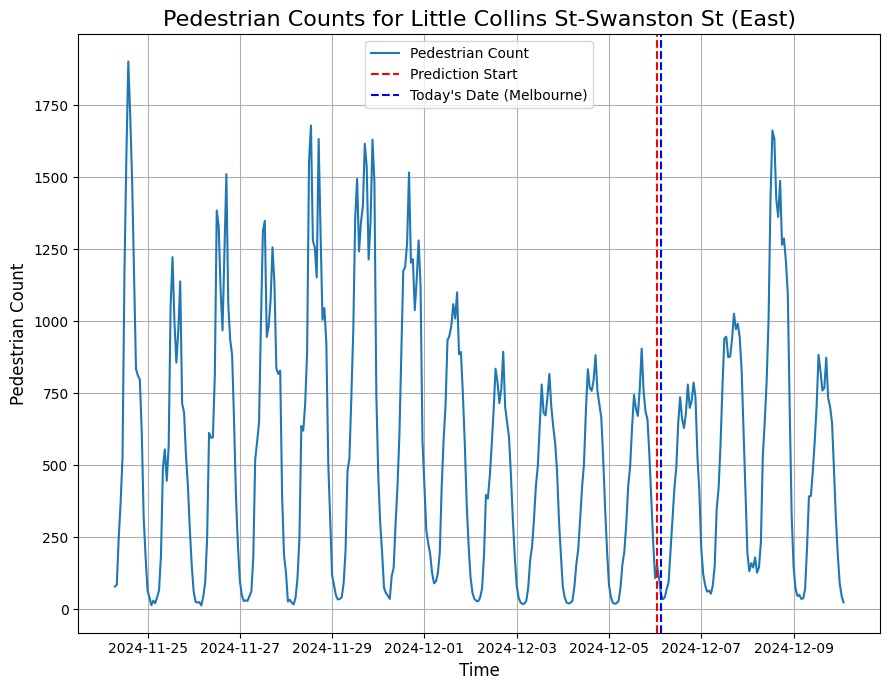

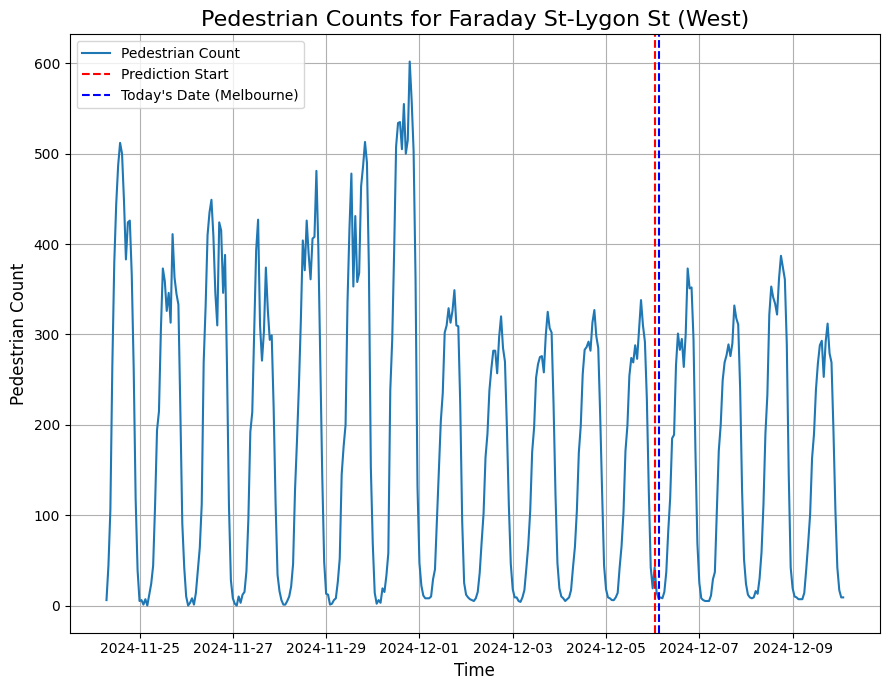

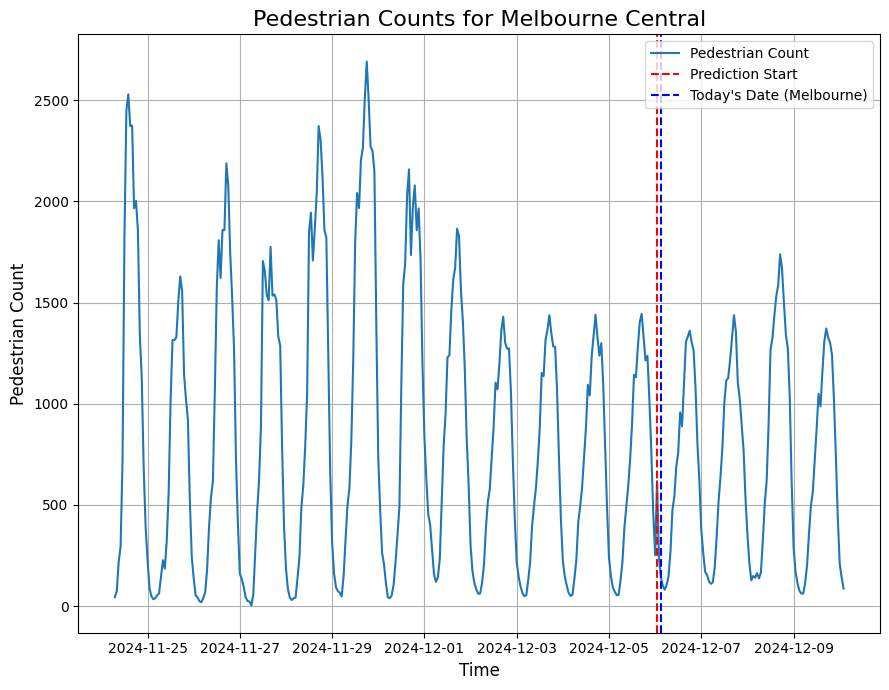

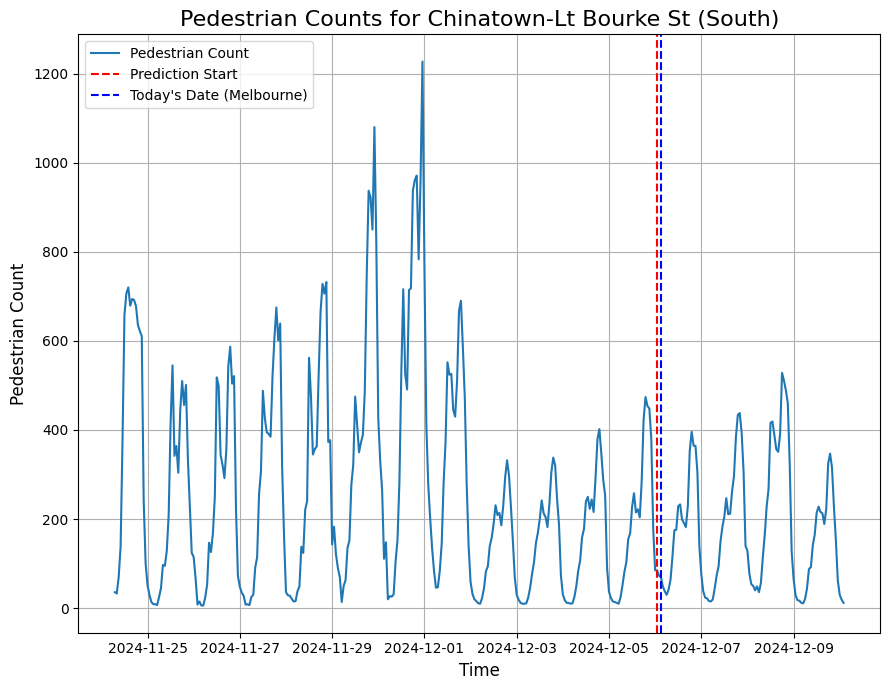

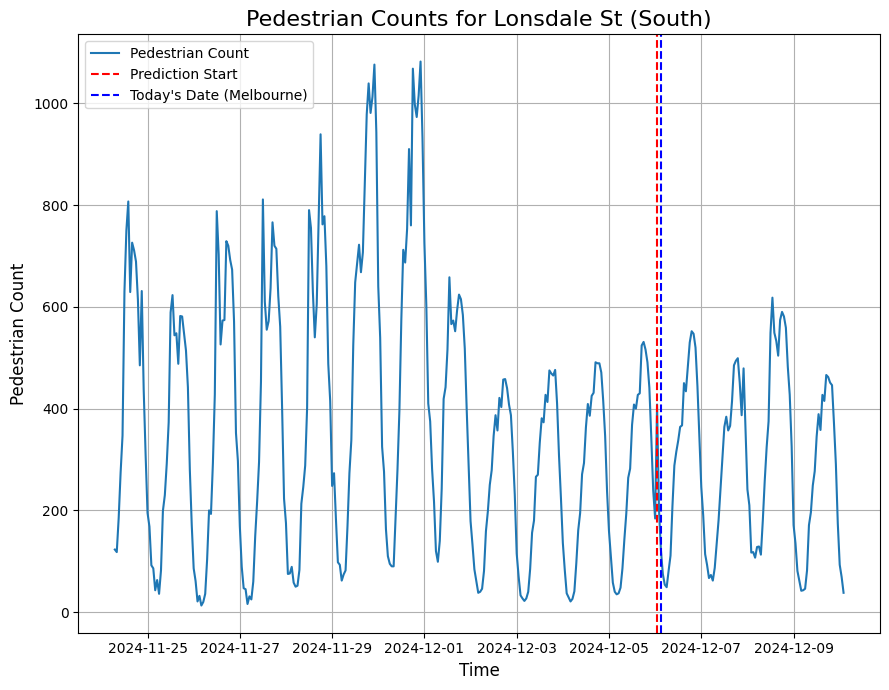

In [377]:
import matplotlib.pyplot as plt
# Plot the pedestrian counts

# Define Melbourne timezone
melbourne_tz = pytz.timezone("Australia/Melbourne")

# Get today's date in Melbourne time
today = datetime.now(melbourne_tz)


#figsize (450, 350)

for street in target_columns:
    plt.figure(figsize=(9, 7))#(figsize=(12, 9))
    plt.plot(final_df.index, final_df[street], label='Pedestrian Count')

    # Add a vertical line at the prediction start
    plt.axvline(x=prediction_start, color='red', linestyle='--', label='Prediction Start')
    plt.axvline(x=today, color='blue', linestyle='--', label="Today's Date (Melbourne)")

    # Add labels, title, and legend
    plt.title(f'Pedestrian Counts for {street}', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Pedestrian Count', fontsize=12)
    plt.legend()
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

## Saving

In [378]:
# drop all future data from today
from datetime import datetime, timedelta
import pytz

# Define Melbourne timezone
melbourne_tz = pytz.timezone("Australia/Melbourne")

# Get current time in Melbourne
now_melbourne = datetime.now(melbourne_tz)

# Define the 3-hour cutoff
cutoff_time = now_melbourne - timedelta(hours=3)

# Drop rows beyond the cutoff
cutoff_df = reordered_df[reordered_df.index <= cutoff_time]

# Save the filtered DataFrame to a CSV
cutoff_df.to_csv('pedestrian_data_filtered.csv', index=True)

cutoff_df

,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),IsPublicHoliday,temp,humidity,rain_1h,...,Faraday St-Lygon St (West)_Lag_1,Melbourne Central_Lag_1,Chinatown-Lt Bourke St (South)_Lag_1,Lonsdale St (South)_Lag_1,Rolling_7_Little Collins St-Swanston St (East),Rolling_7_Faraday St-Lygon St (West),Rolling_7_Melbourne Central,Rolling_7_Chinatown-Lt Bourke St (South),Rolling_7_Lonsdale St (South),Rain_Holiday
datetime_melbourne,,,,,,,,,,,,,,,,,,,,,
